## Tools

In [1]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

In [2]:
api_wrapper = ArxivAPIWrapper(top_k_results = 2, doc_content_chars_max = 500)
arxiv_tool = ArxivQueryRun(api_wrapper = api_wrapper, description = "Query Arxiv Papers")


wikipedia = WikipediaAPIWrapper(top_k_results = 2, doc_content_chars_max = 500)
wikipedia_tool = WikipediaQueryRun(api_wrapper=wikipedia, description = "Query Wikipedia Articles")

In [3]:
# arxiv_tool.invoke("Attention is all you need?")

In [4]:
# wikipedia_tool.invoke("What is the latest paper on quantum computing?")

In [5]:
import os 
from dotenv import load_dotenv
load_dotenv()

TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")


### Tavily Search Tool

In [6]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_tool = TavilySearchResults(api_key = TAVILY_API_KEY, max_results = 2)
# tavily_tool.invoke("What is the latest paper on quantum computing?")

### Combine the tools in the list

In [7]:
tools = [arxiv_tool, wikipedia_tool, tavily_tool]
tools

[ArxivQueryRun(description='Query Arxiv Papers', api_wrapper=ArxivAPIWrapper(arxiv_search=<class 'arxiv.Search'>, arxiv_exceptions=(<class 'arxiv.ArxivError'>, <class 'arxiv.UnexpectedEmptyPageError'>, <class 'arxiv.HTTPError'>), top_k_results=2, ARXIV_MAX_QUERY_LENGTH=300, continue_on_failure=False, load_max_docs=100, load_all_available_meta=False, doc_content_chars_max=500)),
 WikipediaQueryRun(description='Query Wikipedia Articles', api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from '/Users/kushalbanda/AI-Engineer/.venv/lib/python3.12/site-packages/wikipedia/__init__.py'>, top_k_results=2, lang='en', load_all_available_meta=False, doc_content_chars_max=500)),
 TavilySearchResults(max_results=2, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********')))]

## Initialize the LLM Model

In [8]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model = "gpt-4o-mini", temperature = 0)
llm_with_tools = llm.bind_tools(tools = tools)

# llm_with_tools.invoke("What is the latest paper on quantum computing?")

## Workflow

In [9]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage, HumanMessage # Human message or AI message
from typing import Annotated # Labelling
from langgraph.graph.message import add_messages # Reducers in LangGraph

In [10]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [11]:
# Entire Chatbot with LangGraph
from IPython.display import Image, display
from langgraph.graph.state import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

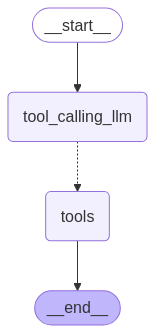

In [12]:
# Nodes
def tool_calling_llm(state: State) -> State:
    """
    This function is used to call the LLM with the tools
    """
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

# Build the graph
builder = StateGraph(State)
builder.add_node('tool_calling_llm', tool_calling_llm)
builder.add_node('tools', ToolNode(tools))

# Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges('tool_calling_llm', tools_condition)
builder.add_edge('tools', END)

# Compile the graph
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
result = graph.invoke({"messages": [HumanMessage(content="What is the latest paper on Machine Learning?")]})
result["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: arxiv

Published: 2019-09-08
Title: Lecture Notes: Optimization for Machine Learning
Authors: Elad Hazan
Summary: Lecture notes on optimization for machine learning, derived from a course at
Princeton University and tutorials given in MLSS, Buenos Aires, as well as
Simons Foundation, Berkeley.

Published: 2018-11-11
Title: An Optimal Control View of Adversarial Machine Learning
Authors: Xiaojin Zhu
Summary: I describe an optimal control view of adversarial machine learning, where the
dynamical system i
